## 프로젝트 : Segmentation map으로 도로 이미지 만들기
### U-Net Generator
***
#### STEP 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
-어떠한 방법을 사용했는지 적기  

#### STEP 2.  U-Net Generator를 사용하기.
-이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.  

#### STEP 3. 테스트 수행하기
-모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.  

#### STEP 4. 시각화하기
-1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.   

#### STEP 5. 로그남기기
-모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.   
***
#### 평가문항
**1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.**  
-데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.  

**2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.**  
-U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.    

**3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.**  
-10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.  
***
#### STEP 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
-어떠한 방법을 사용했는지 적기  
***

In [1]:
#학습데이터 가져오기
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


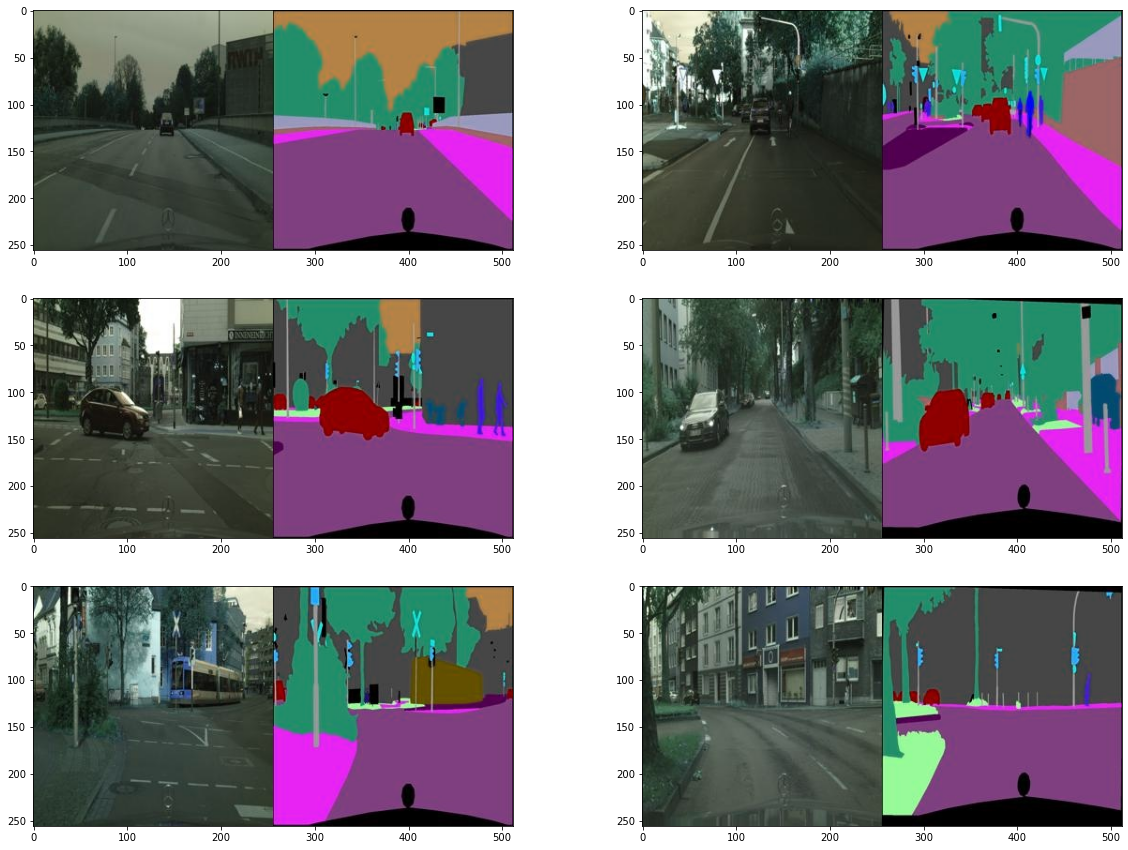

In [2]:
#학습 이미지 확인하기
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

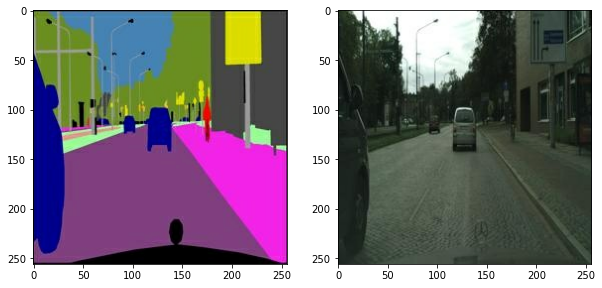

In [3]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image,real_image  = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

In [4]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(input_image, real_image):
    stacked = tf.concat([input_image, real_image], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

1000개밖에 되지 않는 학습데이터를 더 늘려주기 위하여 아래와 같은 Augmentation을 적용합니다.  
1. 두 이미지를 채널 축으로 연결합니다.(tf.concat)
2. 연결된 이미지중 50%확률로 Reflect padding 또는 Constant padding를 적용합니다.(tf.pad)  
3. 2의 결과에서 (256,256,6)크기를 가진 이미지를 임의로 잘라냅니다.(tf.image.random_crop)  
4. 3의 결과를 50%확률로 가로로 뒤집습니다.(tf.image.random_flip_left_right)
5. 4의 결과를 50%확률로 세로로 뒤집습니다.(tf.image.random_flip_up_down)
6. 5의 결과를 50%확률로 회전시킵니다.(tf.image.rot90)

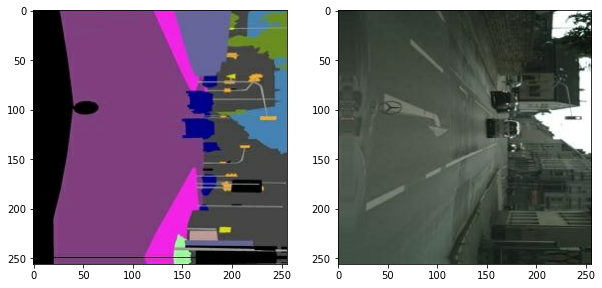

In [5]:
from tensorflow import data

def get_train(img_path):
    input_image, real_image = load_img(img_path)
    input_image, real_image = apply_augmentation(input_image, real_image)
    return input_image, real_image

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, real_image = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_image[0].astype(np.uint8))

#### STEP 2.  U-Net Generator를 사용하기.
-이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.  
-Generator

In [6]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [7]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [8]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

-Discriminator

In [9]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [10]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
        #위의 for문을 사용해서 아래의 block1~block6를 쉽게 생성할 수도 있다.
        
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [11]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

-모델 학습하기

In [12]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [13]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [14]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [15]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9798                     
L1_loss:0.3100                     
Discriminator_loss:1.2843

EPOCH[1] - STEP[20]                     
Generator_loss:1.0164                     
L1_loss:0.2285                     
Discriminator_loss:1.2682

EPOCH[1] - STEP[30]                     
Generator_loss:0.8464                     
L1_loss:0.2105                     
Discriminator_loss:1.3355

EPOCH[1] - STEP[40]                     
Generator_loss:1.3063                     
L1_loss:0.2035                     
Discriminator_loss:1.5882

EPOCH[1] - STEP[50]                     
Generator_loss:0.8320                     
L1_loss:0.1704                     
Discriminator_loss:1.1874

EPOCH[1] - STEP[60]                     
Generator_loss:0.9493                     
L1_loss:0.1764                     
Discriminator_loss:1.1532

EPOCH[1] - STEP[70]                     
Generator_loss:1.0039                     
L1_loss:0.1786                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.6956                     
L1_loss:0.1832                     
Discriminator_loss:0.9854

EPOCH[3] - STEP[80]                     
Generator_loss:1.0282                     
L1_loss:0.1822                     
Discriminator_loss:1.2695

EPOCH[3] - STEP[90]                     
Generator_loss:1.6969                     
L1_loss:0.1731                     
Discriminator_loss:0.5416

EPOCH[3] - STEP[100]                     
Generator_loss:1.1497                     
L1_loss:0.1884                     
Discriminator_loss:0.8374

EPOCH[3] - STEP[110]                     
Generator_loss:1.0698                     
L1_loss:0.2302                     
Discriminator_loss:0.5282

EPOCH[3] - STEP[120]                     
Generator_loss:2.3920                     
L1_loss:0.1864                     
Discriminator_loss:0.3873

EPOCH[3] - STEP[130]                     
Generator_loss:2.6078                     
L1_loss:0.1716                

EPOCH[5] - STEP[130]                     
Generator_loss:0.7230                     
L1_loss:0.1755                     
Discriminator_loss:0.9856

EPOCH[5] - STEP[140]                     
Generator_loss:1.8272                     
L1_loss:0.1777                     
Discriminator_loss:0.5205

EPOCH[5] - STEP[150]                     
Generator_loss:1.7655                     
L1_loss:0.1547                     
Discriminator_loss:0.5465

EPOCH[5] - STEP[160]                     
Generator_loss:0.3372                     
L1_loss:0.1763                     
Discriminator_loss:1.4721

EPOCH[5] - STEP[170]                     
Generator_loss:1.6129                     
L1_loss:0.1962                     
Discriminator_loss:0.3217

EPOCH[5] - STEP[180]                     
Generator_loss:2.8214                     
L1_loss:0.1926                     
Discriminator_loss:0.9033

EPOCH[5] - STEP[190]                     
Generator_loss:1.3028                     
L1_loss:0.1826             

EPOCH[7] - STEP[190]                     
Generator_loss:1.8669                     
L1_loss:0.1779                     
Discriminator_loss:1.3108

EPOCH[7] - STEP[200]                     
Generator_loss:1.3735                     
L1_loss:0.2210                     
Discriminator_loss:0.4458

EPOCH[7] - STEP[210]                     
Generator_loss:1.6732                     
L1_loss:0.1958                     
Discriminator_loss:0.2921

EPOCH[7] - STEP[220]                     
Generator_loss:1.5618                     
L1_loss:0.1740                     
Discriminator_loss:1.1020

EPOCH[7] - STEP[230]                     
Generator_loss:1.4492                     
L1_loss:0.1587                     
Discriminator_loss:0.8090

EPOCH[7] - STEP[240]                     
Generator_loss:1.7407                     
L1_loss:0.2066                     
Discriminator_loss:0.2961

EPOCH[7] - STEP[250]                     
Generator_loss:1.9580                     
L1_loss:0.1819             

EPOCH[9] - STEP[250]                     
Generator_loss:0.6873                     
L1_loss:0.2080                     
Discriminator_loss:1.5952

EPOCH[10] - STEP[10]                     
Generator_loss:0.8630                     
L1_loss:0.1906                     
Discriminator_loss:0.6430

EPOCH[10] - STEP[20]                     
Generator_loss:1.8625                     
L1_loss:0.1924                     
Discriminator_loss:0.4834

EPOCH[10] - STEP[30]                     
Generator_loss:0.8160                     
L1_loss:0.1957                     
Discriminator_loss:0.9771

EPOCH[10] - STEP[40]                     
Generator_loss:0.6217                     
L1_loss:0.1622                     
Discriminator_loss:0.9438

EPOCH[10] - STEP[50]                     
Generator_loss:2.1202                     
L1_loss:0.1633                     
Discriminator_loss:0.9840

EPOCH[10] - STEP[60]                     
Generator_loss:0.7243                     
L1_loss:0.1931             

#### STEP 3. 테스트 수행하기
-모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.  

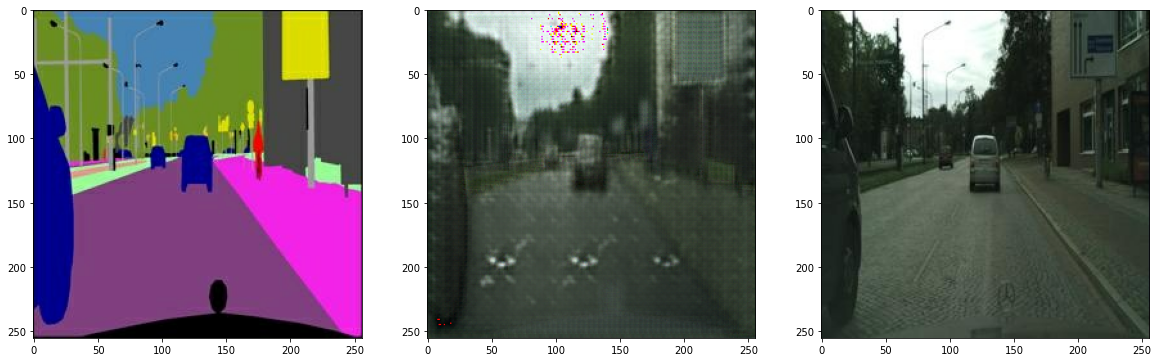

In [16]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
input_image, real_image = load_img(f)

pred = generator(tf.expand_dims(input_image, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(input_image))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(real_image))

#### STEP 4. 시각화하기
-1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.    

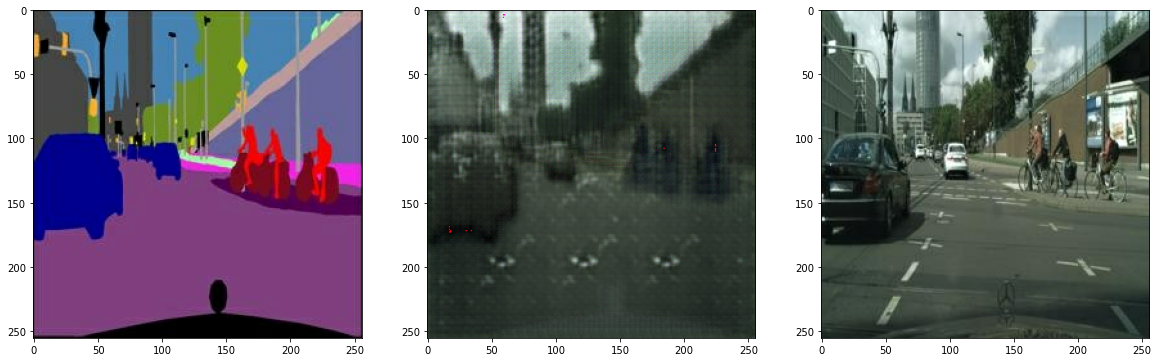

In [17]:
test_ind = 2

f = data_path + os.listdir(data_path)[test_ind]
input_image, real_image = load_img(f)

pred = generator(tf.expand_dims(input_image, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(input_image))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(real_image))

#### 회고록  
이번노드는 U-Net을 활용하여 Segmentation map으로 도로 이미지를 만드는 작업을 진행하였다.  
학습시에는 스케치를 채색하는 작업을 진행했는데 뭔가 갑자기 확 건너뛴 느낌이었다.  
그래도 생각보다 부드럽게 작업들이 진행되어서 살짝 당황했다.  
나름대로 재밌는 노드였다고 생각한다.  